In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

## Network topology and initialization functions

In [2]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer

def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

def init_mask(m,n):
    return np.ones((n, m))

def get_full_mask(params):
    return [ np.array(p[0])*0. + 1 for p in params]

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return ( [init_mask(m,n) for m,n in zip(sizes[:-1],sizes[1:])],  [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)])

# Predictor

In [3]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def predict(params, mask, image):
    # per-example predictions
    activations = image
    for m,(w,b) in zip(mask[:-1],params[:-1]):
        outputs = jnp.dot(m * w, activations) + b
        activations = relu(outputs)

    final_mask, (final_w, final_b) = mask[-1], params[-1]
    logits = jnp.dot(final_mask * final_w, activations) + final_b
    return logits - logsumexp(logits)

In [4]:
# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None,None, 0))

# Utilities

In [5]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, mask, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params,mask, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, mask, images, targets):
  preds = batched_predict(params, mask, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, mask, x, y):
  grads = grad(loss)(params,mask, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

# Data and Co.

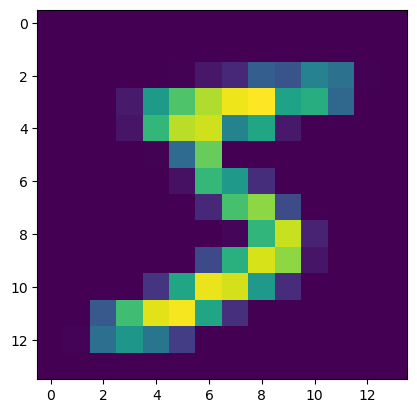

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras.datasets as tfds
import numpy as np
onehot = lambda y : np.concatenate([
        (y == cifra)[:,None] * 1.
    for cifra in np.arange(10)
], axis = 1)

(x_train, y_train), (x_test, y_test) = tfds.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = np.array([ np.array(Image.fromarray(x).resize((14,14))) for x in x_train])
x_test  = np.array([ np.array(Image.fromarray(x).resize((14,14))) for x in x_test])

plt.imshow(x_train[0])

x_train = x_train.reshape(-1,14*14)
x_test  = x_test.reshape(-1,14*14)
y_test  = onehot(y_test)
y_train = onehot(y_train)



In [7]:
layer_sizes = [14*14, 10, 10, 10]
mask, params = init_network_params(layer_sizes, random.PRNGKey(0))
batched_predict(params,mask,x_train[:3])

DeviceArray([[-2.2986622, -2.3003092, -2.291753 , -2.3153772, -2.3010228,
              -2.3106387, -2.3008556, -2.309747 , -2.3073661, -2.2904146],
             [-2.2967458, -2.2978039, -2.290876 , -2.317737 , -2.3022969,
              -2.3089628, -2.301722 , -2.3104868, -2.3080108, -2.2915494],
             [-2.296296 , -2.2996867, -2.2964408, -2.3144908, -2.3035498,
              -2.3099043, -2.3052185, -2.307092 , -2.3107967, -2.2827616]],            dtype=float32)

# Training

In [8]:
layer_sizes = [14*14, 10, 10, 10]
step_size = 0.01
batch_epochs = 500
num_epochs = batch_epochs * 10
batch_size = 128
n_targets = 10
mask, params = init_network_params(layer_sizes, random.PRNGKey(0))

In [9]:
import time
mask, params = init_network_params(layer_sizes, random.PRNGKey(0))
for epoch in range(num_epochs):
    start_time = time.time()
    for i in range(10):
        batch = np.random.choice(len(x_train), size = 500)
        x,y = x_train[batch],y_train[batch]

    params = update(params, mask, x, y)
    epoch_time = time.time() - start_time

    train_acc = accuracy(params, mask, x_train, y_train)
    test_acc = accuracy(params, mask,  x_test, y_test)
    if epoch % batch_epochs == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(train_acc))
        print("Test set accuracy {}".format(test_acc))

Epoch 0 in 0.30 sec
Training set accuracy 0.10300000011920929
Test set accuracy 0.10599999874830246
Epoch 500 in 0.00 sec
Training set accuracy 0.1673833280801773
Test set accuracy 0.1678999960422516
Epoch 1000 in 0.00 sec
Training set accuracy 0.5487499833106995
Test set accuracy 0.5453999638557434
Epoch 1500 in 0.00 sec
Training set accuracy 0.7706500291824341
Test set accuracy 0.779699981212616
Epoch 2000 in 0.00 sec
Training set accuracy 0.8059166669845581
Test set accuracy 0.8149999976158142
Epoch 2500 in 0.00 sec
Training set accuracy 0.8244500160217285
Test set accuracy 0.8319999575614929
Epoch 3000 in 0.00 sec
Training set accuracy 0.8372666835784912
Test set accuracy 0.840399980545044
Epoch 3500 in 0.00 sec
Training set accuracy 0.8505666851997375
Test set accuracy 0.8518999814987183
Epoch 4000 in 0.00 sec
Training set accuracy 0.8676166534423828
Test set accuracy 0.8648999929428101
Epoch 4500 in 0.00 sec
Training set accuracy 0.8806000351905823
Test set accuracy 0.87889999151

# Sparsification

## Definiamo la distanza $d$ su $\mathcal P$
<center> $d(\theta,\theta') = || f_{\theta} - f_{\theta'} ||_{L^2(\Omega)}$ </center>

In [11]:
import jax
full_mask = get_full_mask(params)

def d(params_1, mask_1, params_2, mask_2 ):
    omega_sample = np.random.choice(255, size = (10000,14*14))
    return jnp.sum( (batched_predict(params_1, mask_1, omega_sample) - batched_predict(params_2, mask_2, omega_sample) )**2 )
d = jax.jit(d)
d_grad = jax.grad(d)
d_grad = jax.jit(d_grad)

params_perturbed = [ (p[0] + np.random.normal(size = p[0].shape) * .00001 ,p[1]) for p in params]

d(params,full_mask,params_perturbed,full_mask)

DeviceArray(0.7304523, dtype=float32)

# LOOP di calcolo

In [44]:
import os

def delete_previous_sparsification():
    folder_name = "sparsification"
    for root, dirs, files in os.walk(folder_name, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))

def save_params(params,identificativo):
    folder_name = "sparsification/%d" % identificativo
    os.mkdir(folder_name)
    for i,p in enumerate(params):
        np.savetxt(folder_name + ("/param_%d_weights.csv" % (i)), np.array(p[0]), delimiter=',', newline='\n' )
        np.savetxt(folder_name + ("/param_%d_bias.csv" % (i)), np.array(p[1]), delimiter=',', newline='\n' )
        
def save_details(params,mask,cmp_params,identificativo):
    output = np.zeros(3)
    output[0] = accuracy(params,mask,x_test,y_test)
    output[1] = accuracy(params,mask,x_train,y_train)
    output[2] = d(cmp_params,full_mask,new_params,mask)
    folder_name = "sparsification/%d" % identificativo
    np.savetxt(folder_name + "/details.csv", output)

In [ ]:
# trovo il peso piú piccolo
import numpy as np

# inizializzo la maschera piena
full_mask = get_full_mask(params)
# inizializzo la maschera da svuotare
mask = get_full_mask(params)

def clone_params(params):
    return [  [ np.array(p[0]).copy(),np.array(p[1]).copy()] for p in params]

def adjust(params, mask, cmp_params, full_mask):
    new_params = clone_params(params)
    alfa       = 1e-11
    while alfa > 1e-14 :
        gradiente = d_grad(params,mask,cmp_params,full_mask)
        new_new_params = clone_params(new_params)
        for n,g in zip(new_new_params,gradiente):
            n[0] = n[0] - alfa * g[0]
            n[1] = n[1] - alfa * g[1]
            
        if(d(new_new_params,mask,cmp_params,full_mask) < d(new_params,mask,cmp_params,full_mask)):
            new_params = new_new_params
            alfa *= 1.001
        else:
            alfa *= 0.5
    return new_params

def prune(params, mask, cmp_params, doAdjust = True):
    minimo = 1e16
    minimo_idx = 0
    minimo_i   = 0
    minimo_j   = 0
    
    for idx,p in enumerate(params):
        #print(idx)
        for i,row in enumerate(p[0]):
            #print("\t%d" % i , minimo)
            for j,el in enumerate(row):
                if params[idx][0][i,j] != 0.:
                    new_params = clone_params(params)
                    new_params[idx][0][i,j] = 0.
                    distanza =  d(cmp_params,full_mask,new_params,mask)
                    if(distanza < minimo):
                        minimo = distanza
                        minimo_idx = idx
                        minimo_i   = i
                        minimo_j   = j
                    if minimo == 0:         # if the minimum becomes zero then the current weight doees not affect distance in P space
                        # non ha bisogno di aggiustamento
                        mask[minimo_idx][minimo_i,minimo_j]          = 0. # setto la maschera  a 0
                        return new_params
    new_params = clone_params(params)
    new_params[minimo_idx][0][minimo_i,minimo_j] = 0.
    
    mask[minimo_idx][minimo_i,minimo_j]          = 0. # setto la maschera  a 0
    # ha bisogno di aggiustamento
    if doAdjust:
        new_params = adjust(new_params, mask, cmp_params,full_mask)
    
    return new_params

delete_previous_sparsification()
new_params = clone_params(params)
for i in range(500):
    new_params = prune(new_params, mask, params, True)
    NZ = np.sum([ (p[0] != 0).sum() for p in new_params]) # non zero entries
    save_params(new_params, NZ)
    save_details(new_params,mask,params, NZ)
    print(accuracy(new_params,mask,  x_test, y_test) , NZ)

0.89 2159
0.89 2158
0.89 2157
0.89 2156
0.89 2155
0.89 2154
0.89 2153
0.89 2152
0.89 2151
0.89 2150
0.89 2149
0.89 2148
0.89 2147
0.89 2146
0.89 2145
0.89 2144
0.89 2143
0.89 2142
0.89 2141
0.89 2140
0.89 2139
0.89 2138
0.89 2137
0.89 2136
0.89 2135
0.89 2134
0.89 2133
0.89 2132
0.89 2131
0.89 2130
0.89 2129
0.89 2128
0.89 2127
0.89 2126
0.89 2125
0.89 2124
0.89 2123
0.89 2122
0.89 2121
0.89 2120
0.89 2119
0.89 2118
0.89 2117
0.89 2116
0.89 2115
0.89 2114
0.89 2113


In [ ]:
import matplotlib.pyplot as plt

for n,p in zip(new_params,params):
    axs = plt.figure(figsize=(3,1),dpi=600).subplots(1,2)
    axs = axs.flatten()
    axs[0].set_title("sparsified %.2f" % ( (n[0] > 0.).sum() / (p[0] > 0).sum() ) )
    axs[0].imshow(n[0] != 0., vmin = 0.,vmax = 1.,aspect='auto') 
    axs[1].set_title("original")
    axs[1].imshow(p[0] != 0., vmin = 0.,vmax = 1.,aspect='auto')

#  Comparing prediction

<function matplotlib.pyplot.show(close=None, block=None)>

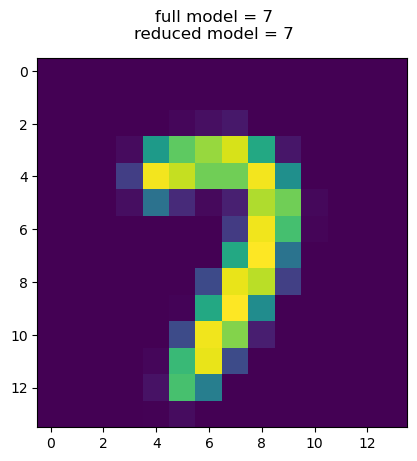

In [194]:
n = 1300
sample = x_train[n]
y_hat_full = predict(params, full_mask, sample).argmax()
y_hat_red  = predict(new_params, mask, sample).argmax()
plt.imshow(sample.reshape(14,14))
plt.suptitle("full model = %d\nreduced model = %d" % (y_hat_full,y_hat_red) )
plt.show

### Weight distribution

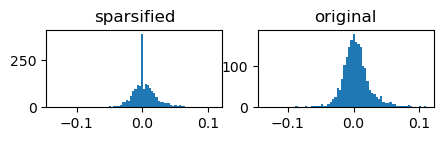

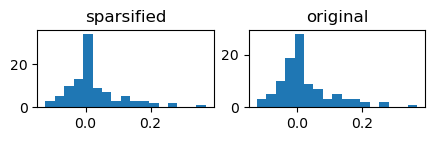

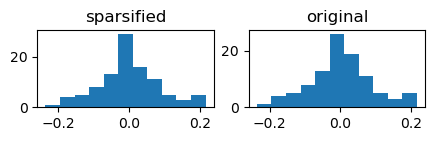

In [192]:
import matplotlib.pyplot as plt

for n,p in zip(new_params,params):
    axs = plt.figure(figsize=(5,1)).subplots(1,2)
    axs = axs.flatten()
    axs[0].set_title("sparsified")
    axs[0].hist(n[0].flatten(), bins = 'auto')
    
    axs[1].set_title("original")
    axs[1].hist(p[0].flatten(), bins = 'auto')